In [1]:
import numpy
import h5py
import pandas

from toposample import TopoData, Config
from toposample.data import read_h5_dataset

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from figure_helper import FigureHelper

"""
Main config file. This file specifies the paths to all the result files and allows us to read the results.
"""
cfg = Config("../working_dir_mn_sz50/config/common_config.json")

fn_metrics = cfg._cfg['analyzed']['struc_parameters']
fn_db_metrics = cfg._cfg['analyzed']['database']
fn_manifold_acc = cfg._cfg['analyzed']['classifier_components_results']
fn_features_acc = cfg._cfg['analyzed']['classifier_features_results']
fn_tribe_struc_params = cfg._cfg['analyzed']['struc_parameters']
fn_tribe_gids = cfg._cfg['analyzed']['tribes']

fhlpr = FigureHelper()
F = fhlpr("Figure 6")


In [2]:
data_metrics = TopoData(fn_metrics)
topo_db = pandas.read_pickle(fn_db_metrics)

read_scores = read_h5_dataset("scores")

manifold_acc = TopoData(fn_manifold_acc, follow_link_functions={"data_fn": (read_scores, True)})["data_fn"]
features_acc = TopoData(fn_features_acc, follow_link_functions={"data_fn": (read_scores, True)})["data_fn"]

tribe_struc_params = TopoData(fn_tribe_struc_params)
tribe_gids = TopoData(fn_tribe_gids)['gids']

tribe_struc_params.data["Mean tribe community coupling"] =\
tribe_gids.map(lambda x: numpy.nanmean(topo_db["comm_coupling"].loc[x]))

<ipython-input-2-f5b2ca36ed7a>:13: RuntimeWarning: Mean of empty slice
  tribe_gids.map(lambda x: numpy.nanmean(topo_db["comm_coupling"].loc[x]))


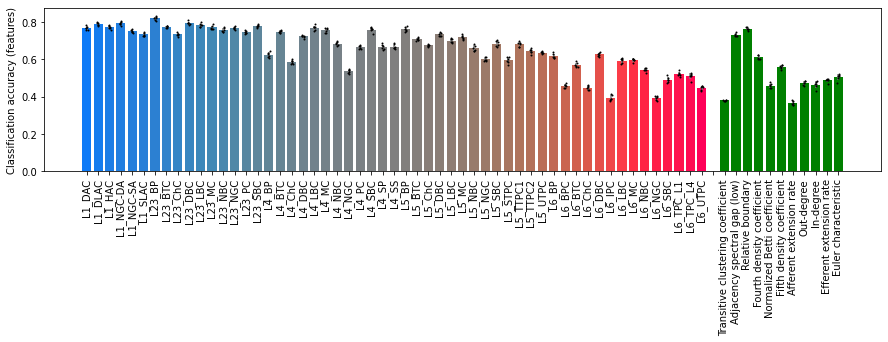

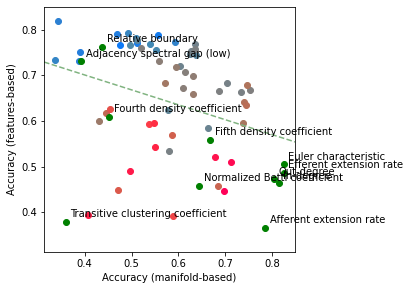

In [3]:
from matplotlib import cm

specs_params = ['Transitive clustering coefficient', 'Adjacency spectral gap (low)', 'Relative boundary', 'Fourth density coefficient', 'Normalized Betti coefficient', 'Fifth density coefficient', 'Afferent extension rate', 'Out-degree', 'In-degree', 'Efferent extension rate', 'Euler characteristic']
specs_random = features_acc.filter(sampling="M-type").labels_of("specifier")

manifold_acc_pool = manifold_acc.pool(["index"], func=numpy.hstack)

cols = cm.RdBu_r(numpy.linspace(0.0, 1.0, len(specs_random)))[:, :3]
cols = 1.5 * cols / cols.sum(axis=1, keepdims=True)
cols[cols > 1.0] = 1.0

fig = plt.figure(figsize=(15, 3))
ax = fig.gca()
for x, spec in enumerate(specs_random):
    data_points = features_acc.get2(sampling="M-type", specifier=spec)
    ax.bar(x, numpy.nanmean(data_points), color=cols[x])
    ax.errorbar(x, numpy.mean(data_points), yerr=numpy.std(data_points), color='grey')
    ax.plot(x + 0.2 * (numpy.random.rand(len(data_points)) - 0.5), data_points,
            ls='None', marker='.', ms=2, color='black')

for x, spec in enumerate(specs_params):
    data_points = features_acc.get2(sampling="Parameter", specifier=spec)
    ax.bar(x + 1 + len(specs_random), numpy.nanmean(data_points), color="green")
    ax.errorbar(x + 1 + len(specs_random), numpy.nanmean(data_points),
                yerr=numpy.nanstd(data_points), color='grey')
    ax.plot(x + 1 + len(specs_random) + 0.2 * (numpy.random.rand(len(data_points)) - 0.5),
            data_points, ls='None', marker='.', ms=2, color='black')

ax.set_xticks(range(len(specs_random) + len(specs_params) + 1))
_ = ax.set_xticklabels(specs_random + [''] + specs_params, rotation='vertical')
ax.set_ylabel("Classification accuracy (features)")
F.save(fig, "Panel-F")

fig = plt.figure(figsize=(4.5, 4.5))
ax = fig.gca()
all_x = []; all_y = []
for x, spec in enumerate(specs_random):
    data_ftrs = features_acc.get2(sampling="M-type", specifier=spec)
    data_mnfd = manifold_acc.get2(sampling="M-type", specifier=spec)
    ax.plot(numpy.mean(data_mnfd), numpy.mean(data_ftrs), marker='o', ls='None', color=cols[x])
    all_x.append(numpy.mean(data_mnfd)); all_y.append(numpy.mean(data_ftrs))

for x, spec in enumerate(specs_params):
    data_ftrs = features_acc.get2(sampling="Parameter", specifier=spec)
    data_mnfd = manifold_acc_pool.get2(sampling="Parameter", specifier=spec)
    x, y = numpy.nanmean(data_mnfd), numpy.nanmean(data_ftrs)
    ax.plot(x, y, marker='o', ls='None', color='green')
    ax.text(x+0.01, y+0.01, spec)
    if not numpy.isnan(y):
        all_x.append(x); all_y.append(y)

data_fit = numpy.polyfit(all_x, all_y, deg=1)

ax.set_xlabel("Accuracy (manifold-based)")
ax.set_ylabel("Accuracy (features-based)")
ylim = numpy.vstack([ax.get_ylim(), ax.get_xlim()])
ylim = numpy.array([ylim[:, 0].min(), ylim[:, 1].max()])
ax.set_xlim(ylim); ax.set_ylim(ylim)
ax.plot(ylim, data_fit[1] + data_fit[0] * ylim, color=[0.5, 0.7, 0.5], ls='--')
F.save(fig, "Panel-G")


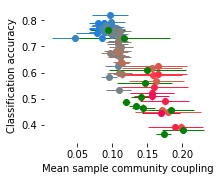

In [4]:
fig = plt.figure(figsize=(3, 2.5))
ax = fig.gca()

features_mean_acc = features_acc.map(numpy.nanmean)
for i, mtype in enumerate(specs_random):
    x = tribe_struc_params["Mean tribe community coupling"].get2(specifier=mtype)
    y = features_acc.get2(specifier=mtype)
    ax.errorbar(numpy.nanmean(x), numpy.nanmean(y), marker='o', color=cols[i],
                yerr=numpy.nanstd(y), xerr=numpy.nanstd(x), lw=1)

for i, mtype in enumerate(specs_params):
    x = tribe_struc_params["Mean tribe community coupling"].get2(specifier=mtype)
    y = features_acc.get2(specifier=mtype)
    ax.errorbar(numpy.nanmean(x), numpy.nanmean(y), marker='o', color='green',
                yerr=numpy.nanstd(y), xerr=numpy.nanstd(x), lw=1)

ax.set_xlabel("Mean sample community coupling")
ax.set_ylabel("Classification accuracy")

plt.box(False)

F.save(fig, fn="Panel-H")